## From Pandas to Dask

When Dask reads a CSV file, it only looks at a small sample from the start of the file (or the first file if using a glob pattern) to infer the data types for each column. This is in contrast to pandas, which reads the entire file before inferring data types.

Let's say you have a CSV file where some first rows of a column are integers and the next row is a string. If you read the file with pandas, it would correctly infer the data type of the column as object. But Dask would only see the first few rows of integers and infer the data type as int.

When Dask then tries to process the rest of the data and encounters the string in the next row, it will throw a type mismatch error, as it expected an int, not a string.

In [1]:
import dask.dataframe as dd
ddf = dd.read_csv("sample.csv")

# Try to compute the Dask DataFrame
try:
    print(ddf.compute())
except Exception as e:
    print("Caught an exception:", e)


Caught an exception: Mismatched dtypes found in `pd.read_csv`/`pd.read_table`.

+--------+--------+----------+
| Column | Found  | Expected |
+--------+--------+----------+
| x      | object | int64    |
+--------+--------+----------+

The following columns also raised exceptions on conversion:

- x
  ValueError("invalid literal for int() with base 10: 'a'")

Usually this is due to dask's dtype inference failing, and
*may* be fixed by specifying dtypes manually by adding:

dtype={'x': 'object'}

to the call to `read_csv`/`read_table`.


### Avoiding error:

In [2]:
import dask.dataframe as dd

# Specify dtypes directly using the dtype keyword
ddf = dd.read_csv('sample.csv', dtype={'x': 'object'})

try:
    print(ddf.compute())
except Exception as e:
    print("Caught an exception:", e)

     x
0    1
1    2
2    3
3    4
4    5
..  ..
95  96
96  97
97  98
98  99
99   a

[100 rows x 1 columns]


----

### Load the airline dataset into a Dask dataframe.

In [3]:
import dask.dataframe as dd
from dask.distributed import Client
import os

client = Client(n_workers=4)
print(client)

ddf = dd.read_csv(
    os.path.join("data", "nycflights", "*.csv"),
    parse_dates={"Date": [0, 1, 2]},
    dtype={"TailNum": str, "CRSElapsedTime": float, "Cancelled": bool},
) # Specify dtypes directly using the dtype keyword.

ddf.head()

<Client: 'tcp://127.0.0.1:51164' processes=4 threads=4, memory=15.68 GiB>


,Date,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,...,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,Diverted
0,1990-01-01,1,1621.0,1540,1747.0,1701,US,33,NaN,86.0,...,NaN,46.0,41.0,EWR,PIT,319.0,NaN,NaN,False,0
1,1990-01-02,2,1547.0,1540,1700.0,1701,US,33,NaN,73.0,...,NaN,-1.0,7.0,EWR,PIT,319.0,NaN,NaN,False,0
2,1990-01-03,3,1546.0,1540,1710.0,1701,US,33,NaN,84.0,...,NaN,9.0,6.0,EWR,PIT,319.0,NaN,NaN,False,0
3,1990-01-04,4,1542.0,1540,1710.0,1701,US,33,NaN,88.0,...,NaN,9.0,2.0,EWR,PIT,319.0,NaN,NaN,False,0
4,1990-01-05,5,1549.0,1540,1706.0,1701,US,33,NaN,77.0,...,NaN,5.0,9.0,EWR,PIT,319.0,NaN,NaN,False,0


### ddf.head():
This is similar to pandas' head() function.

However, because Dask is lazily evaluated, ddf.head() triggers a small computation where Dask reads in the start of the file to get the first few rows.

It’s worth noting that Dask DataFrame may not show the same results as Pandas' head(), especially when your Dask DataFrame is composed of multiple partitions, and it could only display the results from the first partition.

----

### Visualizing Dask

The ddf.visualize() function is used to draw a diagram of the underlying task graph (a visualization of the computations that Dask is performing under the hood). The task graph is a directed acyclic graph (DAG) that describes the sequence of computations and their dependencies.

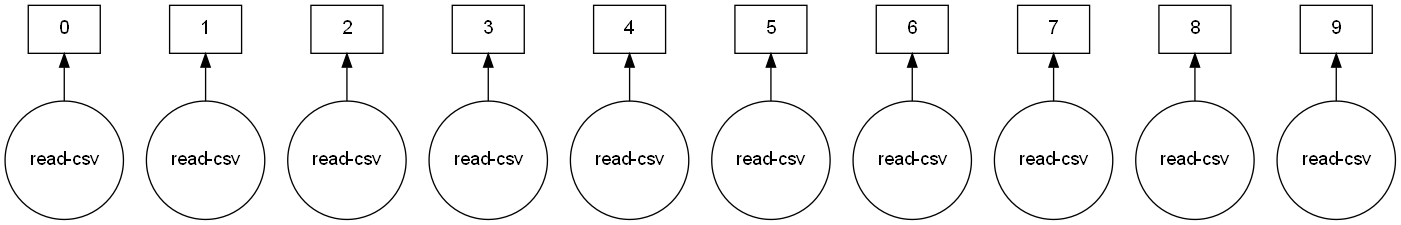

In [4]:
ddf.visualize()

In [5]:
len(ddf)


2611892

In [6]:
ddf.tail()


,Date,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,...,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,Diverted
269176,1999-12-27,1,1645.0,1645,1830.0,1901,UA,1753,N516UA,225.0,...,205.0,-31.0,0.0,LGA,DEN,1619.0,7.0,13.0,False,0
269177,1999-12-28,2,1726.0,1645,1928.0,1901,UA,1753,N504UA,242.0,...,214.0,27.0,41.0,LGA,DEN,1619.0,5.0,23.0,False,0
269178,1999-12-29,3,1646.0,1645,1846.0,1901,UA,1753,N592UA,240.0,...,220.0,-15.0,1.0,LGA,DEN,1619.0,5.0,15.0,False,0
269179,1999-12-30,4,1651.0,1645,1908.0,1901,UA,1753,N575UA,257.0,...,233.0,7.0,6.0,LGA,DEN,1619.0,5.0,19.0,False,0
269180,1999-12-31,5,1642.0,1645,1851.0,1901,UA,1753,N539UA,249.0,...,232.0,-10.0,-3.0,LGA,DEN,1619.0,6.0,11.0,False,0


In [10]:
# Number of non-cancelled flights per airport 
flights_per_airport = ddf[ddf['Cancelled'] == 0]['Origin'].value_counts().compute()
print("Number of non-cancelled flights per airport:")
print(flights_per_airport)

# Average departure delay per airport
avg_delay_per_airport = ddf.groupby('Origin')['DepDelay'].mean().compute()
print("\nAverage departure delay per airport:")
print(avg_delay_per_airport)

# Day of the week with the worst average departure delay per airport
worst_day_per_airport = ddf.groupby(['Origin', 'DayOfWeek'])['DepDelay'].mean().idxmax().compute()
print("\nDay of the week with the worst average departure delay per airport:")
print(worst_day_per_airport)

# Busiest hours
busiest_hours = ddf['DepTime'].value_counts().nlargest(10).compute()
print("\nBusiest hours:")
print(busiest_hours)

Number of non-cancelled flights per airport:
EWR    1139451
LGA     974267
JFK     427243
Name: Origin, dtype: int64

Average departure delay per airport:
Origin
EWR    10.295469
JFK    10.351299
LGA     7.431142
Name: DepDelay, dtype: float64

Day of the week with the worst average departure delay per airport:
0    (EWR, 5)
dtype: object

Busiest hours:
830.0     13950
700.0     12865
800.0     12089
1730.0    11821
1630.0    11566
1830.0    11326
1230.0    11119
730.0     10779
930.0     10740
900.0     10553
Name: DepTime, dtype: int64


---

---

# Exercise 2: Dask_ML

## Step 1: Use Dask as a backend

In [11]:
from sklearn.svm import SVC
from sklearn.datasets import make_classification
from sklearn.model_selection import GridSearchCV
import joblib
import pandas as pd

# Creating the data
X, y = make_classification(n_samples=1000, random_state=0)

# Defining the hyperparameter grid
param_grid = {
    "C": [0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0],
    "kernel": ['rbf', 'poly', 'sigmoid'],
    "shrinking": [True, False]
}

# Setting up the grid search
grid_search = GridSearchCV(SVC(gamma='auto', random_state=0, probability=True),
                           param_grid=param_grid,
                           return_train_score=False,
                           cv=3,
                           n_jobs=-1)


Scikit-learn uses joblib for single-machine parallelism. This lets you train most estimators (anything that accepts an n_jobs parameter) using all the cores of your laptop or workstation.


Alternatively, Scikit-Learn can use Dask for parallelism. This lets you train those estimators using all the cores of your cluster without significantly changing your code. In that case, you have to provide the string dask to the method parallel_backend. Again, have the client-status-window open in order to monitor the workings

In [12]:

# Using Dask as the backend
with joblib.parallel_backend('dask'):
    grid_search.fit(X, y)
    
# Converting the results to a Pandas DataFrame
cv_results = pd.DataFrame(grid_search.cv_results_)
print(cv_results)


    mean_fit_time  std_fit_time  mean_score_time  std_score_time param_C  \
0        0.613471      0.035175         0.149346        0.035960   0.001   
1        0.600983      0.040819         0.113840        0.019171   0.001   
2        0.357547      0.013229         0.037187        0.005491   0.001   
3        0.321229      0.014978         0.028350        0.002252   0.001   
4        0.415725      0.030753         0.029353        0.004086   0.001   
5        0.420391      0.041490         0.038017        0.010255   0.001   
6        0.574032      0.038400         0.140484        0.017976    0.01   
7        0.663906      0.027259         0.138317        0.043922    0.01   
8        0.329447      0.033186         0.036352        0.011160    0.01   
9        0.374189      0.026175         0.031507        0.014197    0.01   
10       0.343753      0.050168         0.034174        0.013887    0.01   
11       0.338566      0.014191         0.034874        0.012542    0.01   
12       0.3

## Step 2: Classify with dask_ml



Use sklearn.model_selection.train_test_split() to split the data in two seperate parts, with 80% trainings-data and 20% test-data. Make two logistic regressors, one from sklearn and one from ml_dask.

Train both of these regressors on the trainings-data and check their validity on basis of the test-data. Experiment with different values for the hyperparameters. Do you see a difference between the results?

Scikit-Learn Logistic Regression Accuracy: 0.82
Dask-ML Logistic Regression Accuracy: 0.825


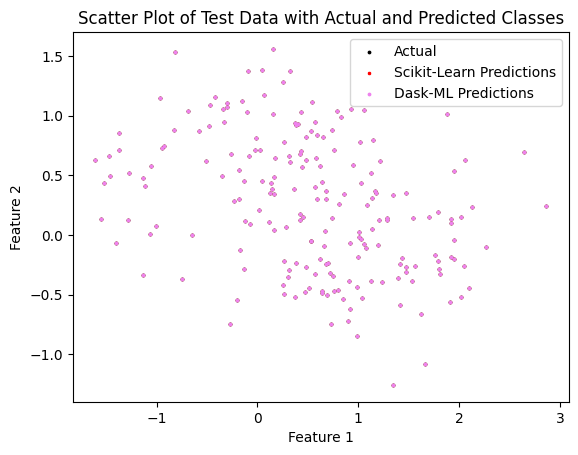

In [81]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from dask_ml.linear_model import LogisticRegression as DaskLogisticRegression

# Generate the moon dataset
X, y = make_moons(n_samples=1000, noise=0.3, random_state=42)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create logistic regression models
sklearn_classifier = LogisticRegression()

# Create Dask-ML logistic regression models
daskml_classifier = DaskLogisticRegression()

# Train the models on the training data
sklearn_classifier.fit(X_train, y_train)
daskml_classifier.fit(X_train, y_train)

# Evaluate the models on the test data
sklearn_accuracy = sklearn_classifier.score(X_test, y_test)
daskml_accuracy = daskml_classifier.score(X_test, y_test)

print("Scikit-Learn Logistic Regression Accuracy:", sklearn_accuracy)
print("Dask-ML Logistic Regression Accuracy:", daskml_accuracy)

# Define colors for actual and predicted classes
actual_color = 'black'
predicted_color1 = 'red'
predicted_color2 = 'violet'

# Scatter plot of test data with actual and predicted classes
plt.scatter(X_test[:, 0], X_test[:, 1], color=actual_color, s=3, label='Actual')
plt.scatter(X_test[:, 0], X_test[:, 1], color=predicted_color1, marker='x', alpha=1, s=3, label='Scikit-Learn Predictions')
plt.scatter(X_test[:, 0], X_test[:, 1], color=predicted_color2, marker='o', alpha=1, s=3, label='Dask-ML Predictions')

plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Scatter Plot of Test Data with Actual and Predicted Classes')
plt.legend()
plt.show()

